In [8]:
import numpy as np
import os, cv2
import h5py
import tifffile
from tqdm import tqdm, trange
from deepreg.predict import unwrapped_predict, normalize_batched_image
from deepreg.model.layer import Warping
import tensorflow as tf
import matplotlib.pyplot as plt



batch_size = 8
label_shape = (30, 3)

### Register a video in batches

In [ ]:
tiff_path = "/store1/alicia/jellyfish/concat_cropped_12000-29999.tif"
checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/long_first_jelly_again/save/ckpt-626"
output_video_path = "/home/brian/data4/brian/PBnJ/out_vids/no_align.mp4"
log_dir = "/home/brian/data4/brian/PBnJ/out_vids/logs"

inputs = tifffile.imread(tiff_path)

In [3]:
os.chdir("/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/scripts")
from register import set_GPU, register
set_GPU(2)

In [32]:
#### FIRST WE'RE GOING TO JUST TRY TO ALIGN TO A SINGLE FRAME
## The first batch of good videos was aligned using ckpt-90, going to switch to 626

# output_video_path = "/home/brian/data4/brian/PBnJ/out_vids/first_frame_align.mp4"
output_video_path = "/home/brian/data4/brian/PBnJ/out_vids/psuedo_col_control_ROIS_nowarp.mp4"
output_h5_path = "/home/brian/data4/brian/PBnJ/out_vids/first_frame_align.h5"
log_dir = "/home/brian/data4/brian/PBnJ/out_vids/logs"

config_path = os.path.join(checkpoint_path.split("/save")[0], "config.yaml")
model = None

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
frames, height, width  = inputs.shape
video = cv2.VideoWriter(output_video_path, fourcc, 20, (width,height), False)

# max_frames = 8
# max_frames = 4000
max_frames = 400
# max_frames = frames

padding = np.array([[0,0],[0,0],[0,0],[1,0]])


# batched_moving_image = normalize_batched_image(inputs[0].astype(np.float32))
# batched_moving_image = np.repeat(batched_moving_image, batch_size, axis=0)
batched_fixed_image = np.repeat(np.expand_dims(inputs[0], axis=0), batch_size, axis=0).astype(np.float32)
batched_fixed_image = np.pad(batched_fixed_image[..., np.newaxis], padding, "constant", constant_values=0)

# video.write(inputs[0])

side_len = width
base = np.arange(side_len)
base_hor = np.tile(base, (side_len, 1))
base_vert = np.rot90(np.tile(base, (side_len, 1)), -1)


base_hor = np.round(base_hor/50)
base_vert = np.round(base_vert/50)

base = (base_hor == base_vert) * base_hor
base = np.pad(base[..., np.newaxis], padding[1:], "constant", constant_values=0)
base = np.tile(base[np.newaxis, ...], (batch_size, 1, 1, 1))

warping = Warping(fixed_image_size=(height, width, 2), batch_size=batch_size)

# try:
for frame in trange(1, max_frames, batch_size):
    if frame + batch_size > frames:
        break

    batched_moving_image = inputs[frame:frame+batch_size].astype(np.float32)
    batched_moving_image = np.pad(batched_moving_image[..., np.newaxis], padding, "constant", constant_values=0)

    
    ddf_output, pred_fixed_image, model = unwrapped_predict(
        batched_fixed_image,
        batched_moving_image,
        log_dir,
        label_shape,
        label_shape,
        model = model,
        model_ckpt_path = checkpoint_path,
        model_config_path = config_path,
    )

    outs = np.empty_like(pred_fixed_image)
    for i in range(batched_moving_image.shape[0]):
        outs[i] = generateNaiveROIs(batched_moving_image[i,...,1])
    
    # outs = base
    # outs = warping(inputs=[ddf_output, outs]).numpy()
    outs = ((outs / np.max(outs)) * 255).astype('uint8')
    # pred_fixed_image = ((pred_fixed_image / np.max(pred_fixed_image)) * 255).astype('uint8')


    for i in range(outs.shape[0]):
        video.write(outs[i][...,1])


cv2.destroyAllWindows()
video.release()
# except:
#     cv2.destroyAllWindows()
#     video.release()
#     print("INTERRUPTED")

  0%|          | 0/50 [00:00<?, ?it/s]

2025-02-28 19:44:19 | WARNING  | Log directory /home/brian/data4/brian/PBnJ/out_vids/logs exists already.
2025-02-28 19:44:19 | WARNING  | Using customized configuration. The code might break if the config doesn't match the saved model.
Built inputs.
Built control points.
Concatenated images.
{'extract_levels': ListWrapper([0, 1, 2, 3]), 'name': 'local', 'num_channel_initial': 16}
Built backbone.
Built DDF.
Built warping.


100%|██████████| 50/50 [04:48<00:00,  5.76s/it]


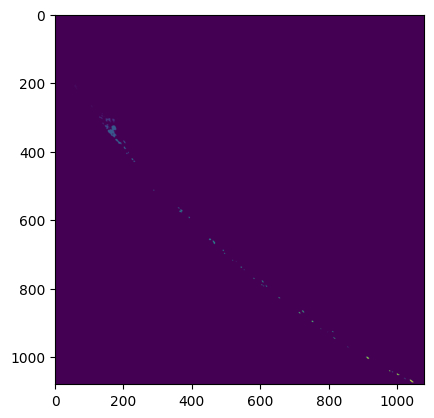

In [27]:
%matplotlib inline

plt.imshow(outs[i][...,1])

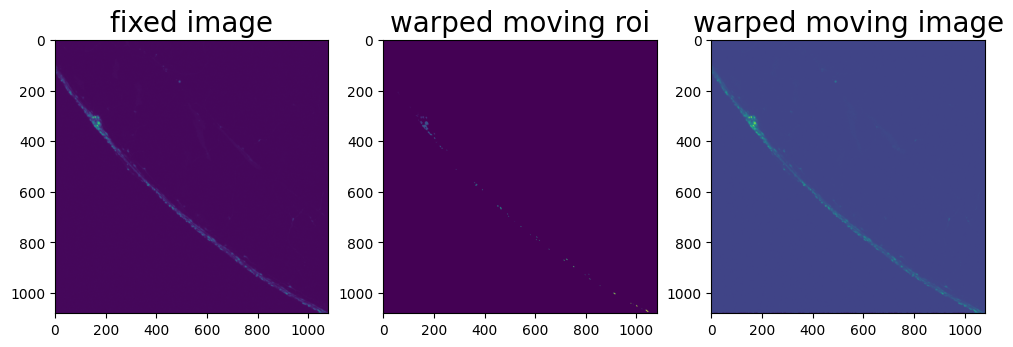

In [30]:
i = 0
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(batched_fixed_image[i,...,1]);
axes[0].set_title("fixed image", fontsize=20);

axes[1].imshow(outs[i,...,1]);
axes[1].set_title("warped moving roi", fontsize=20);

axes[2].imshow(pred_fixed_image[i,...,1]);
axes[2].set_title("warped moving image", fontsize=20);

In [ ]:
output_video_path = "/home/brian/data4/brian/PBnJ/out_vids/beginning-no_align.mp4"

fourcc = cv2.VideoWriter_fourcc(*'mp4v')

images = inputs
# images = images[400:]

frames, height, width  = images.shape

video = cv2.VideoWriter(output_video_path, fourcc, 20, (width,height), False)

for image in trange(max_frames):
    video.write(images[image].astype(np.uint8))

cv2.destroyAllWindows()
video.release()

100%|██████████| 18000/18000 [01:35<00:00, 188.52it/s]


### ROI CODE




In [23]:
from scipy.ndimage import maximum_filter
# import matplotlib.pyplot as plt

# val_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/padded/train/firstDatasetsPaddedAllDims/val"

# img_moving_h5 = f"{val_dir}/moving_images.h5"
# img_fixed_h5 = f"{val_dir}/fixed_images.h5"

# val_roi_moving_h5 = f"{val_dir}/moving_rois.h5"
# val_roi_fixed_h5 = f"{val_dir}/fixed_rois.h5"



def generateNaiveROIs(img):
    shape = img.shape
    size = shape[0] * shape[1]
    blank = np.arange(size).reshape(shape)

    # print(np.percentile(img, 95)
    mask = img > np.percentile(img, 99.9)
    # plt.imshow(mask)

    blank =  blank * mask

    prev = np.array(0)
    while np.any(prev != blank):
        prev = blank
        blank = maximum_filter(blank, size=3, mode='constant')
        blank = blank * mask
    # print(np.unique(blank))

    for i, n in enumerate(np.unique(blank)):
        if n == 0:
            continue
        blank[blank == n] = i


    blank = np.pad(blank[...,np.newaxis], padding[1:], "constant", constant_values=0)
    return blank


# with h5py.File(val_roi_moving_h5, 'w') as vrm,  h5py.File(img_moving_h5, 'r') as oim:
#     generateNaiveROIs(oim, vrm)
# with h5py.File(val_roi_fixed_h5, 'w') as vrf,  h5py.File(img_fixed_h5, 'r') as oif:
#     generateNaiveROIs(oif, vrf)
# with h5py.File(train_roi_fixed_h5, 'w-') as trf,  h5py.File(train_roi_moving_h5, 'w-') as trm: